In [1]:
import numpy as np
import pandas as pd
w = pd.read_csv('db/wisconsin.csv', dtype={'label': 'category'})
w

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label
0,1,5,1,1,1,2,1.0,3,1,1,benign
1,2,5,4,4,5,7,10.0,3,2,1,benign
2,3,3,1,1,1,2,2.0,3,1,1,benign
3,4,6,8,8,1,3,4.0,3,7,1,benign
4,5,4,1,1,3,2,1.0,3,1,1,benign
...,...,...,...,...,...,...,...,...,...,...,...
694,695,3,1,1,1,2,1.0,2,1,1,benign
695,696,2,1,1,1,2,1.0,3,1,1,benign
696,697,5,10,10,10,4,10.0,5,6,3,malignant
697,698,1,1,1,3,2,1.0,1,1,1,benign


In [2]:
# drop label column to leave only numeric columns
w_data = w.drop('label', 1)
w_target = w['label']
# count nan
print(np.sum(np.isnan(w_data)))

patientId            0
clumpThickness       0
cellSize             0
CellShape            0
marginalAdhesion     0
epithelialSize       0
bareNuclei          32
blandChromatin       0
normalNucleoli       0
mitoses              0
dtype: int64


### Use Imputer to replace NaN with median

In [3]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median') # mean, median, most_frequent, constant 
imp.fit(w_data)

w_trans = imp.transform(w_data)
w_trans = pd.DataFrame(w_trans, columns=w_data.columns)

# now we dont have nan
print(np.sum(np.isnan(w_trans)))

patientId           0
clumpThickness      0
cellSize            0
CellShape           0
marginalAdhesion    0
epithelialSize      0
bareNuclei          0
blandChromatin      0
normalNucleoli      0
mitoses             0
dtype: int64


### Get a simple score after logistic regression model with transformed data (no NaN)

In [4]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(w_trans, w_target) # if u fit a model with x having nans, error

# score applied to w_trans without any resampling
score = model.score(w_trans, w_target)
print(f"Accuracy from LogisticRegression: {score}")

Accuracy from LogisticRegression: 0.9699570815450643


### Categorical columns to binary split columns: oysters

In [5]:
# multiple classification data set: ages of oysters are the classes (discrete ages)
filename = 'db/abalone.csv'
dataframe = pd.read_csv(filename, header=None)
dataframe

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [6]:
# separate target column from other columns as x and y
last_ix = len(dataframe.columns)-1
x,y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
x

,0,1,2,3,4,5,6,7
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


### Define format in which you want the encoding and encode it

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# change F,M or I to 3 binary cols

# search and select the columns that are object: column 0 (sex) and change it to bool
categorical = x.select_dtypes(include=['object', 'bool']).columns
t = [('cat', OneHotEncoder(), categorical)] # (name, function, data selected)

# make the actual transformation using t format
col_transform = ColumnTransformer(transformers=t)
view_trans = col_transform.fit_transform(x) # returns an array

transform_df = pd.DataFrame(view_trans) # make a df
transform_df

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
4172,1.0,0.0,0.0
4173,0.0,0.0,1.0
4174,0.0,0.0,1.0
4175,1.0,0.0,0.0


### Column Transformer also works for Scaling transformation, Encoding, etc

In [8]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer


# select integer (age) column to scale it (0.0-1.0) with column transform
numerical = x.select_dtypes(include=['int64', 'float64']).columns
categorical = x.select_dtypes(include=['object', 'bool']).columns
# include a format tuple per transformation
t = [('cat', OneHotEncoder(), categorical), ('num', MinMaxScaler(), numerical)]

# apply the transform with t format
col_transform = ColumnTransformer(transformers=t)
view_trans = col_transform.fit_transform(x)

transform_df = pd.DataFrame(view_trans)
transform_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,1.0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982
1,0.0,0.0,1.0,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261
2,1.0,0.0,0.0,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773
3,0.0,0.0,1.0,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965
4,0.0,1.0,0.0,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313
...,...,...,...,...,...,...,...,...,...,...
4172,1.0,0.0,0.0,0.662162,0.663866,0.146018,0.313441,0.248151,0.314022,0.246637
4173,0.0,0.0,1.0,0.695946,0.647059,0.119469,0.341420,0.294553,0.281764,0.258097
4174,0.0,0.0,1.0,0.709459,0.705882,0.181416,0.415796,0.352724,0.377880,0.305431
4175,1.0,0.0,0.0,0.743243,0.722689,0.132743,0.386931,0.356422,0.342989,0.293473


### Get accuracy of model (with resampling validation) of the data set ignoring categorical column

In [9]:
from sklearn.model_selection import train_test_split

test_size = 0.33
seed = 1
x_train, x_test, y_train, y_test = train_test_split(x.iloc[:,1:], y, test_size = test_size, random_state = seed)
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(x_train, y_train)
results = model.score(x_test, y_test)
print(f"Accuracy: {results * 100}") # percentage of accuracy

Accuracy: 24.22044960116026


### Get accuracy of model (with resampling validation) of the data setwith binary 3 columns (to see if categorical data is improving the prediction)

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.33
seed = 1
x_train, x_test, y_train, y_test = train_test_split(transform_df, y, test_size = test_size, random_state = seed)
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(x_train, y_train)
results = model.score(x_test, y_test)
print(f"Accuracy: {results * 100}") # percentage of accuracy

Accuracy: 25.018129079042783


In [ ]:
y

In [ ]:
x

In [ ]:
#!pip install graphviz

In [11]:
import pandas as pd
url = 'db/housing.csv'
# 13 features and 1 target
names_reg = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT',
            'MEDV']
df_reg = pd.read_csv(url, delim_whitespace=True, names=names_reg)
array_reg = df_reg.values
x_reg = array_reg[:,0:13]
y_reg = array_reg[:,13]
df_reg

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


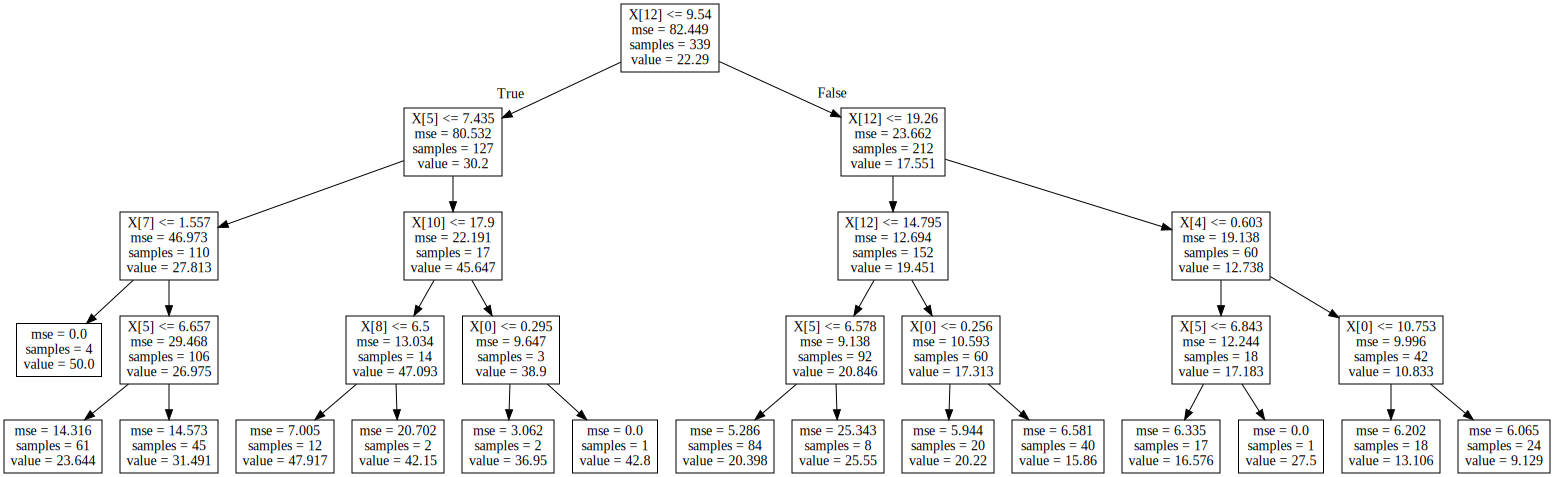

Most useful variables: [ 0  4  5  7  8 10 12]


DecisionTreeRegressor(max_depth=4)

In [12]:
from sklearn.model_selection import train_test_split
import graphviz
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor, export_graphviz

test_size = 0.33
seed = 1
x_train, x_test, y_train, y_test = train_test_split(x_reg, y_reg, test_size = test_size, random_state = seed)
depth = 4 # tree depth
tree = DecisionTreeRegressor(criterion='mse', max_depth=depth) # criteria is the mean absolute error (regression)
tree.fit(x_train, y_train)
subset = np.unique(tree.tree_.feature[tree.tree_.feature>=0])
display(graphviz.Source(export_graphviz(tree)))
print(f"Most useful variables: {subset}") # index of most important columns
tree

In [13]:
graph = graphviz.Source(export_graphviz(tree))
graph.render('tree.png',view=True)

'tree.png.pdf'